## Эмбеддинги текстов
Используем текстовую информацию - объеденим заголовок и описание и получим эмбеддинги для них

In [ ]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import AutoTokenizer

from utils.models import EmbeddingMLP
from utils.training import EmbeddingDataset, train_loop, get_mlp_predictions
from utils.preprocess import preprocess_dataset
from utils.metrics import print_metrics

DEVICE = torch.device("cuda")

/home/dmitry/miniconda3/envs/ML/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train = pd.read_parquet("data/train.parquet")
train["text"] = train["title"] + " " + train["description"]
train_X, train_y = preprocess_dataset(train)
train_X, val_X, train_y, val_y = train_test_split(
    train_X, train_y, random_state=42, test_size=0.1
)

train_img_inds = train_X.index
val_img_inds = val_X.index
img_embeddings = torch.load("data/train_embeddings_large.pt")

train_img_embeddings = img_embeddings[train_img_inds, :]
val_img_embeddings = img_embeddings[val_img_inds, :]

embedding_dim = img_embeddings.shape[1]

In [ ]:
test = pd.read_parquet("data/test.parquet")

test["text"] = test["title"] + " " + test["description"]

In [3]:
train_X, val_X, train_y, val_y = train_test_split(
    train_X, train_y, random_state=42, test_size=0.1
)
train_text_inds = train_X.index
val_text_inds = val_X.index

In [4]:
train_text = train.loc[train_text_inds, "text"]
val_text = train.loc[val_text_inds, "text"]

## W2V эмбеддинги

Обучим на нашем корпусе модель FastText

In [ ]:
# здесь классы, взятые с семинара по Word2Vec, для логирования лосса и удобной генерации эмбеддингов

import re

from gensim.models.callbacks import CallbackAny2Vec
from gensim.models.fasttext import FastText


class LossLogger(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print("Loss after epoch {}: {}".format(self.epoch, loss))
        else:
            print(
                "Loss after epoch {}: {}".format(
                    self.epoch, loss - self.loss_previous_step
                )
            )
        self.epoch += 1
        self.loss_previous_step = loss


class EpochLogger(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 0


class Word2VecTransformer:
    def __init__(self, w2v_model, word_pattern):
        self.w2v_model = w2v_model
        self.word_pattern = word_pattern
        self.re = re.compile(pattern=self.word_pattern)

    def fit(self, X):
        return self

    def transform(self, X):
        X_transformed = np.zeros((len(X), self.w2v_model.wv.vector_size))
        for i, title in enumerate(X):
            title_vector = np.zeros((self.w2v_model.wv.vector_size,))
            tokens = self.re.findall(title.lower())
            length = 1
            for token in tokens:
                if token in self.w2v_model.wv.key_to_index:
                    title_vector += self.w2v_model.wv.get_vector(token)
                    length += 1
            title_vector = title_vector / length
            X_transformed[i] = title_vector

        return X_transformed

In [7]:
sentences_train = train_text.to_list()
sentences_val = val_text.to_list()

WORD_PATTERN = "(?u)\\b\\w\\w+\\b"
reg_exp = re.compile(pattern=WORD_PATTERN)
sentences_train = [reg_exp.findall(s.lower()) for s in sentences_train]
sentences_val = [reg_exp.findall(s.lower()) for s in sentences_val]

In [8]:
embedding_dim = 128

w2v_model = FastText(
    vector_size=embedding_dim,
    window=6,
    min_count=5,
    sg=1,
    epochs=20,
    negative=5,
    workers=10,
    min_n=3,
    max_n=8,
)
w2v_model.build_vocab(sentences_train)
w2v_model.train(
    corpus_iterable=sentences_train,
    total_examples=w2v_model.corpus_count,
    epochs=w2v_model.epochs,
    compute_loss=True,
    callbacks=[LossLogger()],
)

Loss after epoch 0: 0.0
Loss after epoch 1: 0.0
Loss after epoch 2: 0.0
Loss after epoch 3: 0.0
Loss after epoch 4: 0.0
Loss after epoch 5: 0.0
Loss after epoch 6: 0.0
Loss after epoch 7: 0.0
Loss after epoch 8: 0.0
Loss after epoch 9: 0.0
Loss after epoch 10: 0.0
Loss after epoch 11: 0.0
Loss after epoch 12: 0.0
Loss after epoch 13: 0.0
Loss after epoch 14: 0.0
Loss after epoch 15: 0.0
Loss after epoch 16: 0.0
Loss after epoch 17: 0.0
Loss after epoch 18: 0.0
Loss after epoch 19: 0.0


(155100936, 174731740)

In [9]:
print(w2v_model.wv.similar_by_word("куртка", 5))
print(w2v_model.wv.similar_by_word("размер", 5))
print(w2v_model.wv.similar_by_word("большой", 5))

[('ветровка', 0.8574414253234863), ('демисезонная', 0.8483181595802307), ('курточка', 0.8412068486213684), ('куртку', 0.8028903603553772), ('парка', 0.8011391758918762)]
[('размера', 0.7983734011650085), ('разм', 0.7933964133262634), ('31размер', 0.7865718603134155), ('29размер', 0.7785968780517578), ('28размер', 0.7765316963195801)]
[('огромный', 0.6997255086898804), ('маленький', 0.5999629497528076), ('выбор', 0.5913854241371155), ('ассортимент', 0.5695958137512207), ('бoльшой', 0.5530809164047241)]


Лосс по какой-то причине корректно не считается. Тем не менее исходя из примеров выше, получены адекватные эмбеддинги, которые отражают связь между словами.

Сгенерируем эмбеддинги, используя полученную модель и обучим на ней MLP 

In [10]:
w2v_transformer = Word2VecTransformer(
    w2v_model=w2v_model, word_pattern=WORD_PATTERN
)

train_text_embeddings = w2v_transformer.transform(train_text)
val_text_embeddings = w2v_transformer.transform(val_text)

In [11]:
train_text_embeddings = torch.tensor(train_text_embeddings).float()
val_text_embeddings = torch.tensor(val_text_embeddings).float()

In [22]:
train_dataset = EmbeddingDataset(train_text_embeddings, train_y)
val_dataset = EmbeddingDataset(val_text_embeddings, val_y)

train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=512, shuffle=True)

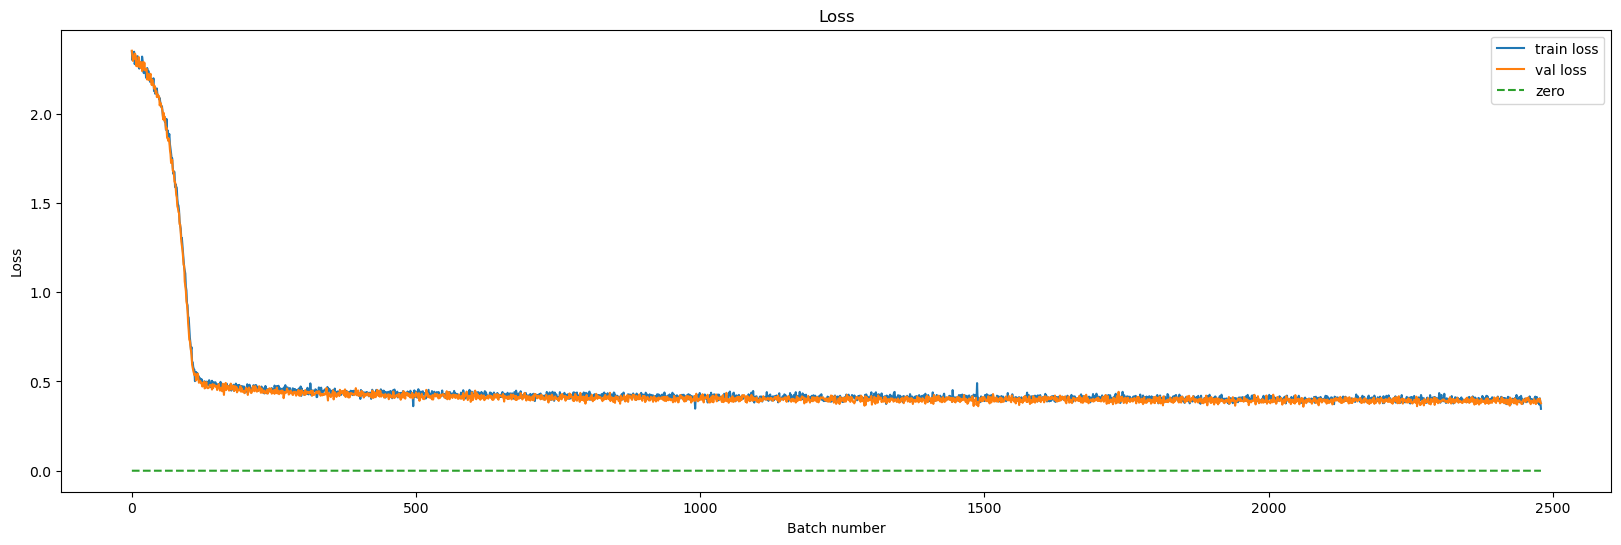

In [23]:
lr = 0.0001
n_epochs = 5
loss_func = nn.L1Loss()

model = EmbeddingMLP(embedding_dim)
model = model.to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.0001)

train_loop(
    n_epochs,
    loss_func,
    model,
    optimizer,
    train_dataloader,
    val_dataloader,
    DEVICE,
)

In [24]:
torch.save(model.state_dict(), "models/w2v_text_embeds_baseline.pth")

In [25]:
model = EmbeddingMLP(embedding_dim).to(DEVICE)
model.load_state_dict(
    torch.load("models/w2v_text_embeds_baseline.pth", weights_only=True)
)

<All keys matched successfully>

In [26]:
val_dataloader = DataLoader(val_dataset, batch_size=512, shuffle=False)
mlp_val_preds = get_mlp_predictions(model, val_dataloader, DEVICE)
print_metrics(val_y, mlp_val_preds)

log_real_weight:
	mae=0.3466
	r2=0.2136
	corr=0.5135
log_real_height:
	mae=0.5497
	r2=0.1232
	corr=0.3754
log_real_length:
	mae=0.3322
	r2=0.0980
	corr=0.3270
log_real_width:
	mae=0.3359
	r2=0.0959
	corr=0.3243
Mean MAE: 0.3911


Качество предсказаний на полученных эмбеддингах сильно ниже, чем на картинках и табличных данных

## BERTA эмбеддинги
Попробуем использовать предобученную более мощную модель - [BERTA](https://huggingface.co/sergeyzh/BERTA), обученную на русских и английских текстах. Эта дистиллированная маленькая версия, в силу чего она работает сильно быстрее других опробованных моделей и требует меньше памяти

In [9]:
import torch
from transformers import AutoModel


def pool(hidden_state, mask, pooling_method="cls"):
    if pooling_method == "mean":
        s = torch.sum(hidden_state * mask.unsqueeze(-1).float(), dim=1)
        d = mask.sum(axis=1, keepdim=True).float()
        return s / d
    elif pooling_method == "cls":
        return hidden_state[:, 0]

In [ ]:
# tokenizer = AutoTokenizer.from_pretrained("ai-forever/FRIDA")
# model = T5EncoderModel.from_pretrained("ai-forever/FRIDA")

# tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")
# model = AutoModelForMaskedLM.from_pretrained(
#     "xlm-roberta-base", output_hidden_states=True
# )

tokenizer = AutoTokenizer.from_pretrained("sergeyzh/BERTA")
model = AutoModel.from_pretrained("sergeyzh/BERTA")

In [ ]:
model = model.eval()
model = model.to(DEVICE)

In [ ]:
# train embeddings
outs = []
with torch.no_grad():
    for i in tqdm(range(0, train.shape[0], 8)):
        text = train.loc[i : i + 7, "text"].to_list()

        tokenized_inputs = tokenizer(
            text,
            max_length=512,
            padding=True,
            truncation=True,
            return_tensors="pt",
        )
        tokenized_inputs["input_ids"] = tokenized_inputs["input_ids"].to(
            DEVICE
        )
        tokenized_inputs["attention_mask"] = tokenized_inputs[
            "attention_mask"
        ].to(DEVICE)
        tokenized_inputs["token_type_ids"] = tokenized_inputs[
            "token_type_ids"
        ].to(DEVICE)
        outputs = model(**tokenized_inputs)
        embeddings = pool(
            outputs.last_hidden_state,
            tokenized_inputs["attention_mask"],
            pooling_method="mean",
        )
        embeddings = embeddings.cpu().detach().numpy()
        outs.append(embeddings)

outs_np = np.concatenate(outs)
np.save("data/train_embeddings_text.npy", outs_np)

100%|██████████| 39114/39114 [1:34:50<00:00,  6.87it/s]  


In [ ]:
# test embeddings
outs = []
with torch.no_grad():
    for i in tqdm(range(0, test.shape[0], 8)):
        text = test.loc[i : i + 7, "text"].to_list()

        tokenized_inputs = tokenizer(
            text,
            max_length=512,
            padding=True,
            truncation=True,
            return_tensors="pt",
        )
        tokenized_inputs["input_ids"] = tokenized_inputs["input_ids"].to(
            DEVICE
        )
        tokenized_inputs["attention_mask"] = tokenized_inputs[
            "attention_mask"
        ].to(DEVICE)
        tokenized_inputs["token_type_ids"] = tokenized_inputs[
            "token_type_ids"
        ].to(DEVICE)
        outputs = model(**tokenized_inputs)
        embeddings = pool(
            outputs.last_hidden_state,
            tokenized_inputs["attention_mask"],
            pooling_method="mean",
        )
        embeddings = embeddings.cpu().detach().numpy()
        outs.append(embeddings)

outs_np = np.concatenate(outs)
np.save("data/test_embeddings_text.npy", outs_np)

100%|██████████| 8785/8785 [21:21<00:00,  6.86it/s]


Теперь попробуем обучить на полученных эмбеддингах MLP

In [ ]:
text_embeddings = torch.tensor(np.load("data/train_embeddings_text.npy"))
embedding_dim = text_embeddings.shape[1]

train_text_embeddings = text_embeddings[train_text_inds, :]
val_text_embeddings = text_embeddings[val_text_inds, :]

In [29]:
train_dataset = EmbeddingDataset(train_text_embeddings, train_y)
val_dataset = EmbeddingDataset(val_text_embeddings, val_y)

train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=512, shuffle=True)

In [30]:
test_text_embeddings = torch.tensor(np.load("data/test_embeddings_text.npy"))
test_dataset = EmbeddingDataset(test_text_embeddings)
test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False)

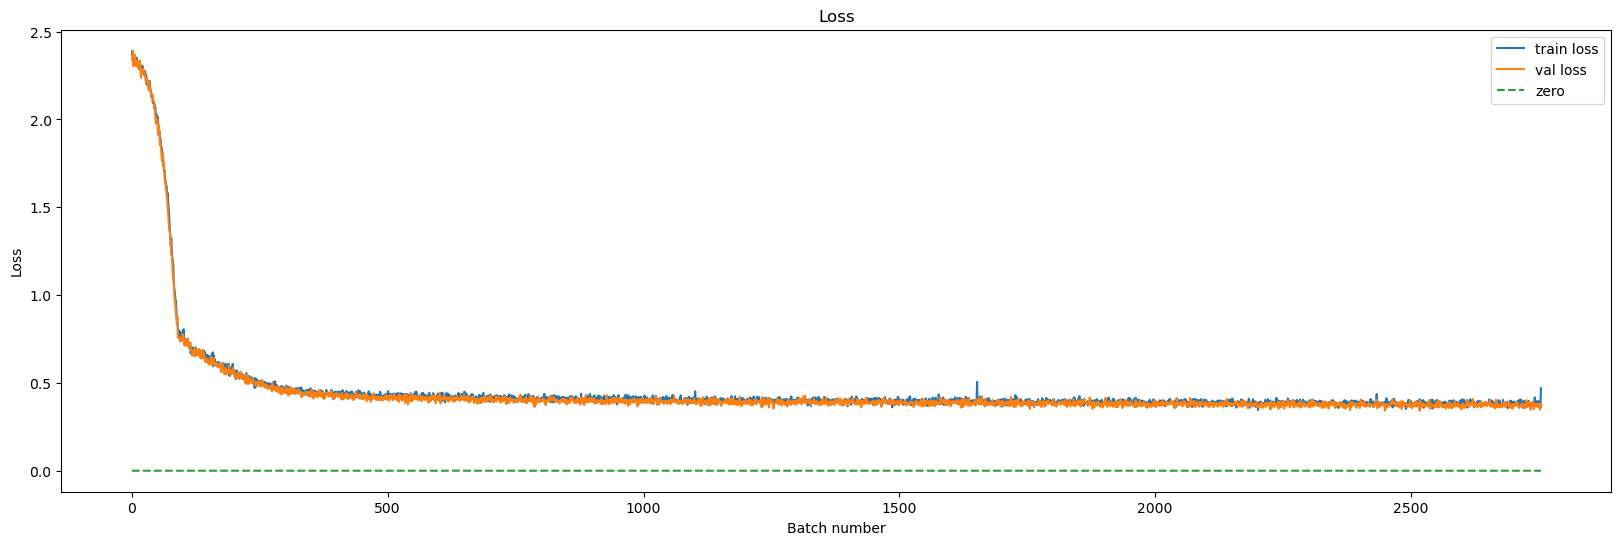

In [ ]:
lr = 0.0001
n_epochs = 5
loss_func = nn.L1Loss()

model = EmbeddingMLP(768)
model = model.to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.0001)

train_loop(
    n_epochs,
    loss_func,
    model,
    optimizer,
    train_dataloader,
    val_dataloader,
    DEVICE,
)

In [ ]:
torch.save(model.state_dict(), "models/mlp_berta_text_embeds.pth")

In [32]:
model = EmbeddingMLP(embedding_dim).to(DEVICE)
model.load_state_dict(
    torch.load("models/mlp_berta_text_embeds.pth", weights_only=True)
)

<All keys matched successfully>

In [33]:
val_dataloader = DataLoader(val_dataset, batch_size=512, shuffle=False)
mlp_val_preds = get_mlp_predictions(model, val_dataloader, DEVICE)
print_metrics(val_y, mlp_val_preds)

log_real_weight:
	mae=0.3190
	r2=0.3252
	corr=0.5963
log_real_height:
	mae=0.5315
	r2=0.1621
	corr=0.4309
log_real_length:
	mae=0.3182
	r2=0.1363
	corr=0.3856
log_real_width:
	mae=0.3221
	r2=0.1319
	corr=0.3775
Mean MAE: 0.3727


Эмбеддинги BERTA получились более информативными, однако все еще хуже чем картиночные и табличные данные. Сохраним предсказания MLP на основании их для дальнейшего использования для обучения CatBoost.

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=False)
mlp_train_preds = get_mlp_predictions(model, train_dataloader, DEVICE)
test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False)
mlp_test_preds = get_mlp_predictions(model, test_dataloader, DEVICE)

In [ ]:
np.save("mlp_predictions/train_mlp_berta_predicitons.npy", mlp_train_preds)
np.save("mlp_predictions/val_mlp_berta_predicitons.npy", mlp_val_preds)
np.save("mlp_predictions/test_mlp_berta_predicitons.npy", mlp_test_preds)